# Step 0: Load Packages and Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix

# Step 1: Data Loading and Preprocessing

In [8]:
# Read your dataset (replace 'marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv' with your dataset path)
train_data = pd.read_csv('styles.csv')
train_data.columns

Index(['Uniq id', 'Product id', 'gender', 'masterCategory', 'Product Category',
       'Product Name', 'baseColour', 'Product Brand', 'season',
       'Product Rating', 'Product Reviews Count', 'usage',
       'Product Description', 'Product Image Url', 'Product ', 'Tags',
       'Product Tags'],
      dtype='object')

In [9]:
train_data = train_data[['Uniq id','Product id', 'Product Rating', 'Product Reviews Count', 'Product Category', 'Product Brand', 'Product Name', 'Product Image Url', 'Product Description', 'Product Tags']]
train_data.head(3)

,Uniq id,Product id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,1,15970,NaN,NaN,Topwear,OPI,Shirts,http://assets.myntassets.com/v1/images/style/p...,Turtle Check Men Navy Blue Shirt,"Shirts,myntassets.com"
1,2,39386,NaN,NaN,Bottomwear,Nice'n Easy,Jeans,http://assets.myntassets.com/v1/images/style/p...,Peter England Men Party Blue Jeans,"Jeans,myntassets.com"
2,3,59263,4.5,29221.0,Watches,Clairol,Watches,http://assets.myntassets.com/v1/images/style/p...,Titan Women Silver Watch,"Watches,myntassets.com"


# Basic Operations

In [10]:
train_data['Product Tags']

0            Shirts,myntassets.com
1             Jeans,myntassets.com
2           Watches,myntassets.com
3       Track Pants,myntassets.com
4           Tshirts,myntassets.com
                   ...            
9995     Sunglasses,myntassets.com
9996         Kurtas,myntassets.com
9997        Jackets,myntassets.com
9998          Heels,myntassets.com
9999     Flip Flops,myntassets.com
Name: Product Tags, Length: 10000, dtype: object

In [11]:
train_data.shape

(10000, 10)

In [12]:
train_data.isnull().sum()

Uniq id                     0
Product id                  0
Product Rating           5613
Product Reviews Count    3311
Product Category            0
Product Brand              28
Product Name                0
Product Image Url           0
Product Description         1
Product Tags                0
dtype: int64

In [13]:
# Fill missing values in 'Product Rating' with a default value (e.g., 0)
train_data['Product Rating'].fillna(0, inplace=True)
# Fill missing values in 'Product Reviews Count' with a default value (e.g., 0)
train_data['Product Reviews Count'].fillna(0, inplace=True)
# Fill missing values in 'Product Category' with a default value (e.g., 'Unknown')
train_data['Product Category'].fillna('', inplace=True)
# Fill missing values in 'Product Brand' with a default value (e.g., 'Unknown')
train_data['Product Brand'].fillna('', inplace=True)
# Fill missing values in 'Product Description' with an empty string
train_data['Product Description'].fillna('', inplace=True)

In [14]:
train_data.isnull().sum()

Uniq id                  0
Product id               0
Product Rating           0
Product Reviews Count    0
Product Category         0
Product Brand            0
Product Name             0
Product Image Url        0
Product Description      0
Product Tags             0
dtype: int64

In [15]:
train_data.duplicated().sum()

0

In [16]:
# make columns shorter
# Define the mapping of current column names to shorter names
column_name_mapping = {
    'Uniq id': 'ID',
    'Product id': 'ProdID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags': 'Tags',
}
# Rename the columns using the mapping
train_data.rename(columns=column_name_mapping, inplace=True)

# Step 2: EDA (Exploratory Data Analysis)

In [17]:
# Basic statistics
num_users = train_data['ID'].nunique()
num_items = train_data['ProdID'].nunique()
num_ratings = train_data['Rating'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")

Number of unique users: 10000
Number of unique items: 10000
Number of unique ratings: 36


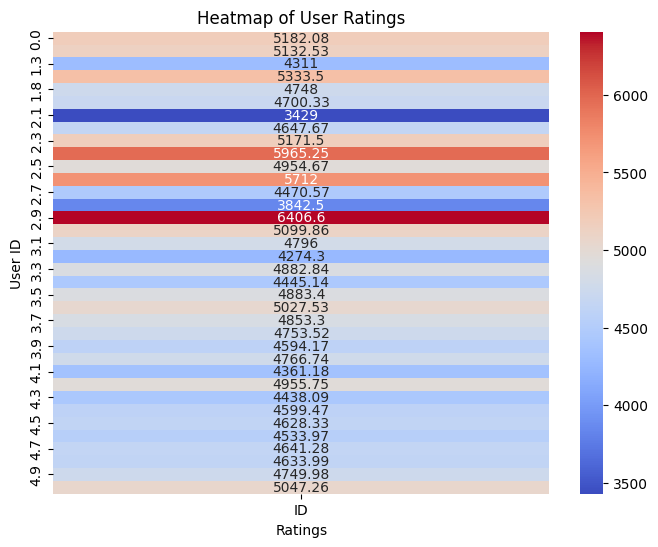

In [18]:
# Pivot the DataFrame to create a heatmap
heatmap_data = train_data.pivot_table('ID', 'Rating')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='coolwarm', cbar=True)
plt.title('Heatmap of User Ratings')
plt.xlabel('Ratings')
plt.ylabel('User ID')
plt.show()

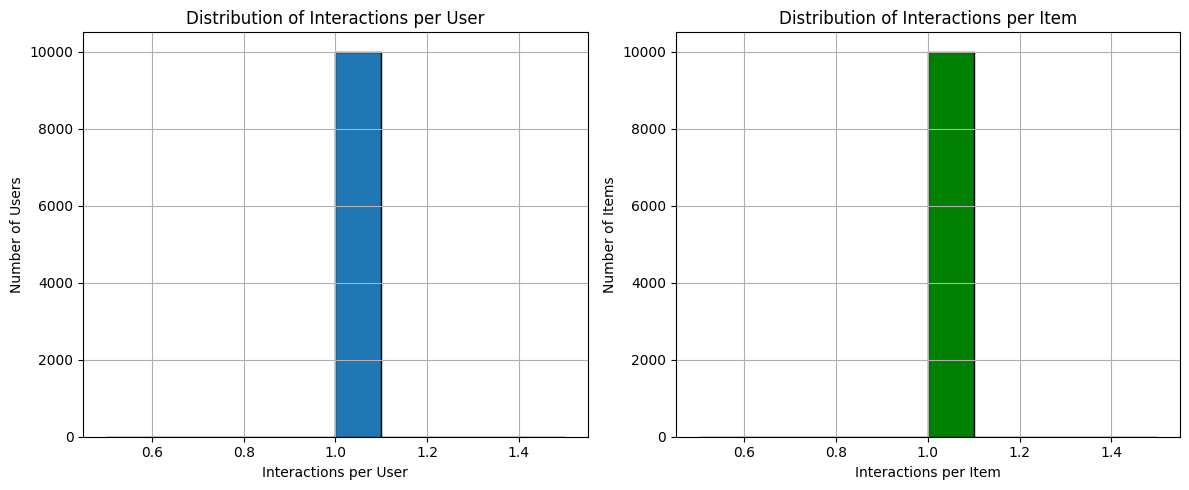

In [19]:
# Distribution of interactions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_data['ID'].value_counts().hist(bins=10, edgecolor='k')
plt.xlabel('Interactions per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User')

plt.subplot(1, 2, 2)
train_data['ProdID'].value_counts().hist(bins=10, edgecolor='k',color='green')
plt.xlabel('Interactions per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions per Item')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Most Popular items')

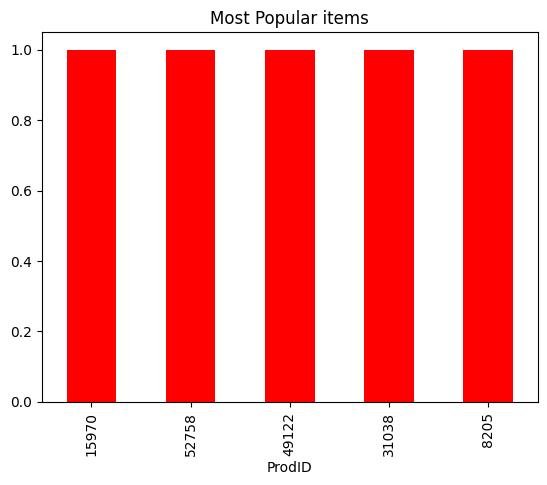

In [20]:
# Most popular items
popular_items = train_data['ProdID'].value_counts().head(5)
popular_items.plot(kind='bar',color='red')
plt.title("Most Popular items")

<Axes: xlabel='Rating'>

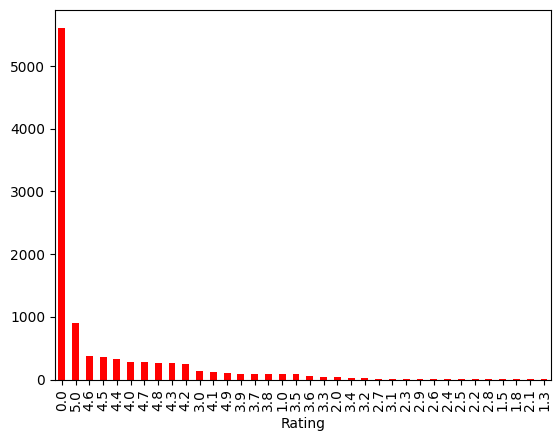

In [21]:
# most rated counts
train_data['Rating'].value_counts().plot(kind='bar',color='red')

# Step 3: Data Cleaning and Tags Creations

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

def clean_and_extract_tags(text):
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)

columns_to_extract_tags_from = ['Category', 'Brand', 'Description']

for column in columns_to_extract_tags_from:
    train_data[column] = train_data[column].apply(clean_and_extract_tags)

In [ ]:
# Concatenate the cleaned tags from all relevant columns
train_data['Tags'] = train_data[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)

# Rating Base Recommendations System

In [22]:
average_ratings = train_data.groupby(['Name','ReviewCount','Brand','ImageURL'])['Rating'].mean().reset_index()

In [23]:
top_rated_items = average_ratings.sort_values(by='Rating', ascending=False)

rating_base_recommendation = top_rated_items.head(10)

In [24]:
rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)
rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)

In [25]:
print("Rating Base Recommendation System: (Trending Products)")
rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']] = rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']]
rating_base_recommendation

Rating Base Recommendation System: (Trending Products)


,Name,ReviewCount,Brand,ImageURL,Rating
1199,Casual Shoes,4,Global,http://assets.myntassets.com/v1/images/style/p...,5
7500,Trousers,0,Ozium,http://assets.myntassets.com/v1/images/style/p...,5
8235,Tshirts,1,L'Oreal Paris,http://assets.myntassets.com/v1/images/style/p...,5
5551,Shirts,39,Clubman Pinaud,http://assets.myntassets.com/v1/images/style/p...,5
8234,Tshirts,1,Klamath Blue Green Algae,http://assets.myntassets.com/v1/images/style/p...,5
8232,Tshirts,1,Karma Organic,http://assets.myntassets.com/assets/images/779...,5
3085,Heels,10,Florida Laboratories,http://assets.myntassets.com/v1/images/style/p...,5
1272,Casual Shoes,16,Lotus,http://assets.myntassets.com/v1/images/style/p...,5
8231,Tshirts,1,KMS California,http://assets.myntassets.com/v1/images/style/p...,5
1264,Casual Shoes,14,Husky,http://assets.myntassets.com/v1/images/style/p...,5


# Content Base Recommendation system (User Preferences or Items similarities)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])
cosine_similarities_content = cosine_similarity(tfidf_matrix_content,tfidf_matrix_content)

In [27]:
item_name = 'Shirts'
item_index = train_data[train_data['Name']==item_name].index[0]

In [28]:
similar_items = list(enumerate(cosine_similarities_content[item_index]))

In [29]:
similar_items = sorted(similar_items, key=lambda x:x[1], reverse=True)
top_similar_items = similar_items[1:10]

recommended_items_indics = [x[0] for x in top_similar_items]

In [30]:
train_data.iloc[recommended_items_indics][['Name','ReviewCount','Brand']]

,Name,ReviewCount,Brand
6,Shirts,10.0,Colgate
7,Shirts,0.0,BMC
15,Shirts,2935.0,Clairol
30,Shirts,50.0,Aveeno
32,Shirts,468.0,Crest
48,Shirts,10.0,Sexy Hair
57,Shirts,0.0,L'Oreal Paris
72,Shirts,978.0,L'Oreal Paris
110,Shirts,23.0,NOW


# Function To Recommend Products for Content Base

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendations(train_data, item_name, top_n=10):
    # Check if the item name exists in the training data
    if item_name not in train_data['Name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()

    # Create a TF-IDF vectorizer for item descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Apply TF-IDF vectorization to item descriptions
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])

    # Calculate cosine similarity between items based on descriptions
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = train_data[train_data['Name'] == item_name].index[0]

    # Get the cosine similarity scores for the item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    # Sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1:top_n+1]

    # Get the indices of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    # Get the details of the top similar items
    recommended_items_details = train_data.iloc[recommended_item_indices][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details

In [32]:
# Example: Get content-based recommendations for a specific item
item_name = 'Shirts'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
6,Shirts,10.0,Colgate,http://assets.myntassets.com/v1/images/style/p...,4.3
7,Shirts,0.0,BMC,http://assets.myntassets.com/v1/images/style/p...,0.0
15,Shirts,2935.0,Clairol,http://assets.myntassets.com/v1/images/style/p...,3.7
30,Shirts,50.0,Aveeno,http://assets.myntassets.com/v1/images/style/p...,0.0
32,Shirts,468.0,Crest,http://assets.myntassets.com/v1/images/style/p...,4.5
48,Shirts,10.0,Sexy Hair,http://assets.myntassets.com/v1/images/style/p...,4.6
57,Shirts,0.0,L'Oreal Paris,http://assets.myntassets.com/v1/images/style/p...,0.0
72,Shirts,978.0,L'Oreal Paris,http://assets.myntassets.com/v1/images/style/p...,3.4


In [33]:
# Example: Get content-based recommendations for a specific item
item_name = 'Sarees'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
161,Sarees,47.0,Prell,http://assets.myntassets.com/v1/images/style/p...,4.9
304,Sarees,46.0,Spring Valley,http://assets.myntassets.com/v1/images/style/p...,4.4
411,Sarees,0.0,L'Oreal Paris,http://assets.myntassets.com/v1/images/style/p...,0.0
804,Sarees,56.0,L'Oreal Paris,http://assets.myntassets.com/v1/images/style/p...,4.0
959,Sarees,1721.0,L'Oreal Paris,http://assets.myntassets.com/v1/images/style/p...,0.0
1065,Sarees,0.0,Clubman Pinaud,http://assets.myntassets.com/v1/images/style/p...,0.0
1564,Sarees,132.0,Energizer,http://assets.myntassets.com/v1/images/style/p...,0.0
1602,Sarees,1.0,Cetaphil,http://assets.myntassets.com/v1/images/style/p...,2.0


# Collaborative Filtering (User Item Similarity)

In [34]:
user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating').fillna(0).astype(int)

In [35]:
user_similarity = cosine_similarity(user_item_matrix)

In [36]:
target_user_id = 4
target_user_index = user_item_matrix.index.get_loc(target_user_id)

In [37]:
user_similarities = user_similarity[target_user_index]

similar_user_indices = user_similarities.argsort()[::-1][1:]

In [38]:
recommend_items = []

for user_index in similar_user_indices:
    rated_by_similar_user = user_item_matrix.iloc[user_index]
    not_rated_by_target_user = (rated_by_similar_user==0) & (user_item_matrix.iloc[target_user_index]==0)
    
    recommend_items.extend(user_item_matrix.columns[not_rated_by_target_user][:10])

recommended_items_details = train_data[train_data['ProdID'].isin(recommend_items)][['Name','ReviewCount','Brand','ImageURL','Rating']]

In [39]:
recommended_items_details.head(10)

,Name,ReviewCount,Brand,ImageURL,Rating
638,Track Pants,8.0,Tussy,http://assets.myntassets.com/v1/images/style/p...,4.8
7036,Sports Shoes,62.0,all,http://assets.myntassets.com/v1/images/style/p...,0.0
7405,Casual Shoes,59.0,Truform,http://assets.myntassets.com/v1/images/style/p...,3.7
7618,Jackets,320.0,Febreze,http://assets.myntassets.com/v1/images/style/p...,0.0
7636,Jackets,15.0,Black Opal,http://assets.myntassets.com/v1/images/style/p...,1.0
7794,Tshirts,1.0,Gelish,http://assets.myntassets.com/v1/images/style/p...,0.0
8012,Caps,956.0,Kotex,http://assets.myntassets.com/v1/images/style/p...,0.0
8168,Swimwear,0.0,ADVANCED CLINICALS,http://assets.myntassets.com/v1/images/style/p...,0.0
8227,Sports Shoes,0.0,Aura Cacia,http://assets.myntassets.com/v1/images/style/p...,0.0
9207,Backpacks,0.0,Navitas Organics,http://assets.myntassets.com/v1/images/style/p...,4.9


# Function That Recommend Items

In [40]:
def collaborative_filtering_recommendations(train_data, target_user_id, top_n=10):
    # Create the user-item matrix
    user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)

    # Calculate the user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Find the index of the target user in the matrix
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # Get the similarity scores for the target user
    user_similarities = user_similarity[target_user_index]

    # Sort the users by similarity in descending order (excluding the target user)
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    # Generate recommendations based on similar users
    recommended_items = []

    for user_index in similar_users_indices:
        # Get items rated by the similar user but not by the target user
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] == 0)

        # Extract the item IDs of recommended items
        recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

    # Get the details of recommended items
    recommended_items_details = train_data[train_data['ProdID'].isin(recommended_items)][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details.head(10)

# Example usage
target_user_id = 4
top_n = 5
collaborative_filtering_rec = collaborative_filtering_recommendations(train_data, target_user_id)
print(f"Top {top_n} recommendations for User {target_user_id}:")
collaborative_filtering_rec

Top 5 recommendations for User 4:


,Name,ReviewCount,Brand,ImageURL,Rating
638,Track Pants,8.0,Tussy,http://assets.myntassets.com/v1/images/style/p...,4.8
7036,Sports Shoes,62.0,all,http://assets.myntassets.com/v1/images/style/p...,0.0
7405,Casual Shoes,59.0,Truform,http://assets.myntassets.com/v1/images/style/p...,3.7
7618,Jackets,320.0,Febreze,http://assets.myntassets.com/v1/images/style/p...,0.0
7636,Jackets,15.0,Black Opal,http://assets.myntassets.com/v1/images/style/p...,1.0
7794,Tshirts,1.0,Gelish,http://assets.myntassets.com/v1/images/style/p...,0.0
8012,Caps,956.0,Kotex,http://assets.myntassets.com/v1/images/style/p...,0.0
8168,Swimwear,0.0,ADVANCED CLINICALS,http://assets.myntassets.com/v1/images/style/p...,0.0
8227,Sports Shoes,0.0,Aura Cacia,http://assets.myntassets.com/v1/images/style/p...,0.0
9207,Backpacks,0.0,Navitas Organics,http://assets.myntassets.com/v1/images/style/p...,4.9


# Hybrid Recommendations